In [ ]:
##############################################################################
# OPTIMIZATION & AI - LAB 03   Pierre LOVITON
##############################################################################

In [1]:
# System imports
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

#Extra library imports
from PIL import Image
from scipy import optimize
import scipy.ndimage as ndi

In [2]:
# User inputs
datadir = 'data'

On the previous lab, we saw that we could check the circularity of healthy or pathological breast cells performing a regression on geometric features, such as area, perimeter or radius. These features are in fact extracted from cell segmentations, $i.e$ manual or automatic delineations of cells' contours on medical images. In this lab, we will see if we can illustrate the circularity of malignant breast cells directly on the input images.

# I. Circle fitting on tumor cell images using the Levenberg-Marquardt algorithm

## a) Design of the algorithm on a specific image from the dataset

In this lab, we will work on the NuCLS dataset (https://sites.google.com/view/nucls/home), containing manual segmentations of breast cells on microscopic images of patient having a breast tumor. The goal of this section is to direclty work on the manual segmentations of the tumor cells, to assess their circularity. We will first design our framework on a single image, and then apply our method on all the available images we have.

We first get all the paths of the manual segmentations and associated microscopic images.

In [204]:
# Get the patient image and manual segmentation paths
segpaths = np.sort(glob.glob(os.path.join(datadir, 'seg', '*.png')))
impaths = np.sort(glob.glob(os.path.join(datadir, 'im', '*.png')))

To design our algorithm, we will work on a specific image. We choose here to select the first segmentation and its associated microscopic image.

<font color='blue'> Question 1: select the path of the first microscopic image and segmentation.</font>

In [205]:
# Path selection
impath = impaths[0]
segpath = segpaths[0]

We will now visualize the images we chose.

<font color='blue'> Question 2:
- Load the microscopic image and its associated manual segmentation.
- Threshold the segmentation to obtain a binary image, *i.e* with tumor pixels having value 1, and other pixels having value 0.
- Display the microscopic image and superimpose the tumor contours in green. </font> 

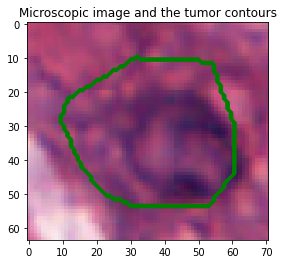

In [206]:
# Load the image
im_arr = np.array(Image.open(impath))

# Load the associated manual segmentation
seg_arr = np.array(Image.open(segpath))

# Threshold the segmentation
#seg_arr = seg_arr <1
seg_arr = (seg_arr>0).astype('int')

# Display the image and the tumor contours
plt.imshow(im_arr)
plt.contour(seg_arr, colors = 'g')
plt.title('Microscopic image and the tumor contours')
plt.show()

Fortunately, we see that this cell looks circular ! To assess quantitively this assumption, we will check if the coordinates of the perimeter of the cell follow a circle equation. Thus, we first need to compute the perimeter region. To that purpose, we can use a distance map on the binary image of the tumor cell. More precisely, a distance map, as implemented in Scipy, is a grey level image, with the value of each of its pixels representing the distance from this pixel to the closest pixel with 0 value in an input binary image. By default, the distance in question is the Euclidian distance.

The following code computes this distance map on the binary tumor cell image.

In [207]:
# Compute the distance map
map_arr = ndi.distance_transform_edt(seg_arr)

We can visualize the output image. We see that it is a grey level image, having null values out of the tumor, and positive values inside the tumor, increasing when getting far away from the tumor border.

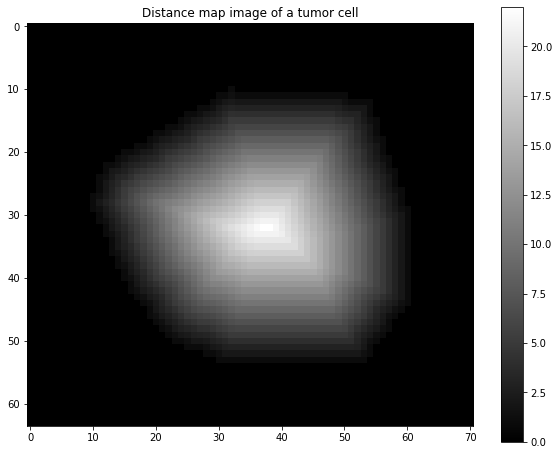

In [208]:
# Display the distance map image
fig, ax = plt.subplots(figsize=(10, 10))
my_show = ax.imshow(map_arr, cmap='gray')
plt.title('Distance map image of a tumor cell')
fig.colorbar(my_show, shrink=0.8);
plt.show()

To obtain the tumor perimeter, we can simply threshold its distance map.

In [209]:
# Threshold the distance map
perim_arr = ((map_arr <= 1) & (seg_arr > 0)).astype(int)

We then obtain the binary image of the tumor cell perimeter.

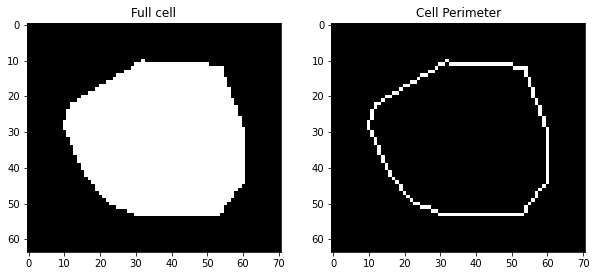

In [210]:
# Display the segmentation and perimeter images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(seg_arr, cmap='gray')
ax[1].imshow(perim_arr, cmap='gray')
ax[0].set_title('Full cell')
ax[1].set_title('Cell Perimeter')
plt.show()

As in the first lab, the coordinates of the perimeter pixels can be computed using the "where" function from Numpy.

In [211]:
[x, y] = np.where(perim_arr == 1)

We want to verify that these coordinates follow a circle equation, *i.e.* there exists a circle of center $(x_c, y_c)$ and radius $r$ such that:

$(x_i - x_c)^2 + (y_i - y_c)^2 = r^2$

for all pixels of coordinate $(x_i, y_i)$ belonging to the perimeter of the tumor cell.

To that purpose, we will optimize an appropriated loss function. But first, as we are now used, we have to initialize the unknown variables, *i.e* the center and the radius of the fitted circle.

For the radius, we assume that a good estimation is the centroid of the pixels belonging to the **full tumor cell (not only the perimeter)**. This centroid is the point $(x_0, y_0)$ such as:

$x_0 = \frac{1}{n}\displaystyle \sum_{i=1}^n x_i$ and $y_0 = \frac{1}{n}\displaystyle \sum_{i=1}^n y_i$

with $(x_i, y_i)$ the coordinates of the pixels belonging to the **full tumor segmentation**, and n the area of the binary image of the full tumor segmentation (the number of pixels having value 1 in this image).

<font color='blue'> Question 3: compute the initial estimation of the circle center $(x_0, y_0)$.
 </font> 

In [212]:
[x0, y0] = np.where(seg_arr == 1)
x0 = np.mean(x0)
y0 = np.mean(y0)

We can now visually assess the relevance of the chosen initial center.

<font color='blue'> Question 4: superimpose on the input microscopic image the contours of the associated tumor cell (in green) and its centroid (in cyan).
 </font> 

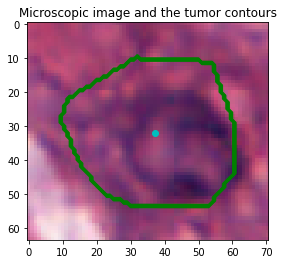

In [213]:
plt.imshow(im_arr)
plt.contour(seg_arr, colors = 'g')
plt.plot(y0,x0, marker="o", color="c")
plt.title('Microscopic image and the tumor contours')
plt.show()

To initialize the radius, we suppose that all the perimeter pixels are at a same distance $r_0$ from the center $(x_0, y_0)$. 
We can formulate this idea with the below formula:

$r_0 = \frac{1}{n}\displaystyle \sum_{i=1}^n \sqrt{(x_i - x_0)^2 + (y_i - y_0)^2} $

with $(x_i, y_i)$ the coordinates of the **perimeter pixels**, and n the area of the binary image of the perimeter.

<font color='blue'> Question 5: compute the initial radius as formulated above. </font>

In [214]:
# Initialize the radius
r0 = np.mean(np.sqrt((x-x0)**2+(y-y0)**2))

Now we have the initial center and radius, we can also visualize the circle we created.

<font color='blue'> Question 6: create the binary image of the initial circle. </font>

In [215]:
# Create the binary image of the (filled) circle of center (x0, y0) and radius r0
sx, sy = seg_arr.shape
y_arr, x_arr = np.meshgrid(range(sy), range(sx))

circle_arr = (((x_arr - x0)**2+(y_arr-y0)**2)<=r0**2).astype(int)

<font color='blue'> Question 7: superimpose on the input microscopic image the contours of the associated tumor cell (in green), its centroid (in cyan) and the contours of the binary image of the initial circle. </font>

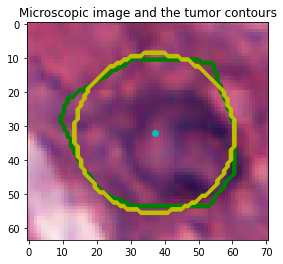

In [216]:
plt.imshow(im_arr)
plt.contour(seg_arr, colors = 'g')
plt.plot(y0,x0, marker="o", color="c")
plt.contour(circle_arr, colors = 'y')
plt.title('Microscopic image and the tumor contours')
plt.show()

The result looks rather good, but we can improve it using optimization.
Among the various available strategies, we choose a very simple one: we linearize the problem, and then use the Levenberg-Marquardt to solve it.

As implemented in Scipy in the "curve_fit" function, we need to compare the measured values, possibly for multiple variables, to the expected modeled values. 

Developping the equation of a circle, and setting $z_i=x_i^2 + y_i^2$, we can show that each point of coordinates $(x_i, y_i)$ belongs to a circle of radius $r$ and center $(x_c, y_c)$ if:

$z_i = \alpha * x_i + \beta * y_i + \gamma$

with $\alpha$,  $\beta$ and $\gamma$ variables possibly depending on $x_c$, $y_c$ or $r$.

<font color='blue'>Question 8: what are the expected values of $\alpha$, $\beta$ and $\gamma$ ?</font>  

<font color='blue'>  
The expected values of 𝛼 , 𝛽 and 𝛾 could be 2xc, 2yc and r**2-xc**2-yc**2</font> 

Thus, the variables to optimize are now $\alpha$, $\beta$ and $\gamma$, while the $z_i=x_i^2+y_i^2$ are the fixed variables. To use the "curve_fit" function from Scipy, we first need to implement the function modelling the $z_i$ values as a linear function of $x_i$ and $y_i$.

<font color='blue'> Question 9: complete the function below, associating to each point $(x_i, y_i)$ its fitted point $z_i$. </font>  

In [217]:
def predict(P, alpha, beta, gamma):

    """
    The function to fit 
    
    
    Parameters
    ----------
    P: 2xn array
        the array containing the x (first line) and y (second line) values 
    alpha: float
        the alpha parameter
    beta: float
        the beta parameter
    gamma: float
        the gamma parameter
        
    Returns
    -------
    pred_p: vector
        the values of the fitted input data (the z values)
        
    Command:
    pred_p = predict(P, alpha, beta, gamma)
    
    """
        
    # Divide the input vector into x and y
    x, y = P[0, :], P[1, :]
    
    # Vector of predictions according to the model 
    pred_p = alpha*x+beta*y+gamma
    
    return pred_p

We will now use the Levenberg-Marquard method to optimize the fitted circle. In our application, the algorithm minimizes the following loss:

 $\displaystyle \frac{1}{2n} \sum_{i=1}^n (z_i - (\alpha * x_i + \beta * y_i + \gamma)) ^ 2$ 
 
 with $n$ the number of samples in the dataset.

<font color='blue'> Question 10: 
- Compute the vector containing the $z_i$ values 
- Initialize the vector of variables, and compute the initial values for $\alpha$, $\beta$ and $\gamma$
- Display the initial loss value
- Perform optimization using the "curve_fit" function from Scipy
- Display the optimized values of $\alpha$, $\beta$ and $\gamma$  
- Display the optimized loss value   
</font>  

In [218]:
# Concatenate x and y
P = np.vstack((x, y))

# Compute the vector of the z_i values
x = P[0, :]
y = P[1, :]

Z = x**2+y**2

# Initialize the vector of variable values
p0 = [2*x0, 2*y0, r0**2-x0**2-y0**2]
alpha = p0[0]
beta = p0[1]
gamma = p0[2]
# Display the initial alpha, beta and gamma values
print("The initial alpha is", p0[0])
print("The initial beta is", p0[1])
print("The initial gamma is", p0[2])

# Display the initial loss value
loss_val = 0.5*np.mean((Z-predict(P,*p0))**2)
print("The initial loss value is", loss_val)

# Fit the model using the Levenberg-Marquard method
lev_marq = optimize.curve_fit(predict,P,Z,p0=p0)

# Display the optimized alpha, beta and gamma values
alpha_final = lev_marq[0][0]
beta_final = lev_marq[0][1]
gamma_final = lev_marq[0][2]

print("The optimized alpha is",alpha_final)
print("The optimized beta is", beta_final)
print("The optimized gamma is", gamma_final)

# Compute and display the final loss value
Z_pred = predict(P,alpha_final,beta_final,gamma_final)
loss_val_final = 0.5*np.mean((Z-Z_pred)**2)
print("The final loss value is",loss_val_final)

The initial alpha is 64.257481648786
The initial beta is 74.15358554488989
The initial gamma is -1861.5376090329207
The initial loss value is 3443.5058710670824
The optimized alpha is 64.15333347075669
The optimized beta is 73.84334584580516
The optimized gamma is -1843.545368370178
The final loss value is 3423.0462295713055


We found the optimized $\alpha$, $\beta$ and $\gamma$ values. To evaluate the fitted circle, we have to compute the associated optimal values for $x_c$, $y_c$ and $r$.

<font color='blue'> Question 11: compute the optimized values for $x_c$, $y_c$ and $r$. Check that they are different from the initial values. </font>  

In [219]:
# Retrieve the parameter values
xc = alpha_final/2
yc = beta_final/2
r = np.sqrt(gamma_final+xc**2+yc**2)
print(x0, y0, r0)
print(xc, yc, r)

32.128740824393 37.076792772444946 23.35394913540154
32.076666735378346 36.92167292290258 23.421723077266268


<font color='blue'> Question 12: superimpose on the input microscopic image the tumor contours (in green) and the contours of the optimized fitted circle (in blue).</font>

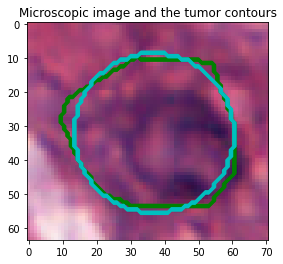

In [220]:
# Compute the binary image of the optimized fitted circle
circle_arr_optimized = (((x_arr - xc)**2+(y_arr-yc)**2)<=r**2).astype(int)
# Display the image, the tumor contours and the optimized fitted circle
plt.imshow(im_arr)
plt.contour(seg_arr, colors = 'g')
plt.contour(circle_arr_optimized, colors = 'c')
plt.title('Microscopic image and the tumor contours')
plt.show()

Visually, our result seems quite good! However, to evaluate its generalization on numerous input images, we need also to quantify our performances. Computing our loss value, which is the half of a Mean Squared Error (MSE), is useful, but difficult to interpret as it can take many different values according to the input image size, or other properties. We are interested in computing metrics, such as the Jaccard index, also called the Intersection over Union (IoU), computed between two binary images $A$ and $B$ as follows:

IoU = $\frac{|A \cap B|}{|A \cup B|}$

with $|C|$ the area of the binary image $C$ 

Thus, the IoU takes its values in $[0, 1]$, 0 meaning that $A$ and $B$ have no overlap, and 1 that $A=B$.

This metric is easier to interpret than the MSE: the IoU between the binary image of the tumor cell segmentation and the binary image of the best fitted circle should be as close as possible to 1.
We will now compute this metric to quantify the performances of our algorithm.

<font color='blue'> Question 13: compute the IoU between the binary image of the cell segmentation and the binary image of its best fitted circle. Conclude on the circularity of the selected tumor cell.</font> 

In [222]:
# Compute and display the IoU metric
iou = np.sum(circle_arr_optimized&seg_arr)/np.sum(circle_arr_optimized|seg_arr)

print('IoU value: {0}'.format(iou))

IoU value: 0.8882289416846654


<font color='green'> The IoU value is very high: the selected cell is very likely to be circular. </font>  

## b) Application of the circle fitting process on all the available images

We are now ready to apply our algorithm on all the available input images.

<font color='blue'> Question 14: perform the optimization process on all the given input segmentations, using a loop. Ensure that the following steps are applied on all images:
* Load the segmentation    
* Initialize the fitted circle
* Compute the initial IoU and loss values
* Optimize the fitted circle
* Compute the fitted IoU and loss values
</font>  

In [182]:
# Initialize the vector containing the initial IoU values
init_ious = []

# Initialize the vector containing the optimized IoU values
final_ious = []

# Initialize the vector containing the initial loss values
init_losses = []

# Initialize the vector containing the optimized loss values
final_losses = []

for i in range(0,len(segpaths)):
    print("\nOptimization for the image",i+1)
    seg_arr = np.array(Image.open(segpaths[i]))
    seg_arr = (seg_arr>0).astype('int')
    
    # Compute the distance map
    map_arr = ndi.distance_transform_edt(seg_arr)
    
    # Threshold the distance map
    perim_arr = ((map_arr <= 1) & (seg_arr > 0)).astype(int)
    
    [x, y] = np.where(perim_arr == 1)    
    
    [x0, y0] = np.where(seg_arr == 1)
    x0 = np.mean(x0)
    y0 = np.mean(y0)
    
    # Initialize the radius
    r0 = np.mean(np.sqrt((x-x0)**2+(y-y0)**2))

    # Create the binary image of the (filled) circle of center (x0, y0) and radius r0
    sx, sy = seg_arr.shape
    y_arr, x_arr = np.meshgrid(range(sy), range(sx))

    circle_arr = (((x_arr - x0)**2+(y_arr-y0)**2)<=r0**2).astype(int)

    # Concatenate x and y
    P = np.vstack((x, y))

    # Compute the vector of the z_i values
    x = P[0, :]
    y = P[1, :]

    Z = x**2+y**2

    # Initialize the vector of variable values
    p0 = [2*x0, 2*y0, r0**2-x0**2-y0**2]
    alpha = p0[0]
    beta = p0[1]
    gamma = p0[2]
    
    # Display the initial loss value and iou
    iou_initial = np.sum(circle_arr&seg_arr)/np.sum(circle_arr|seg_arr)
    loss_val_initial = 0.5*np.mean((Z-predict(P,*p0))**2)
    print("The initial iou is", iou_initial)
    print("The initial loss value is", loss_val_initial)

    # Fit the model using the Levenberg-Marquard method
    lev_marq = optimize.curve_fit(predict,P,Z,p0=p0)
    
    # Display the optimized alpha, beta and gamma values
    alpha_final = lev_marq[0][0]
    beta_final = lev_marq[0][1]
    gamma_final = lev_marq[0][2]
    
    xc = alpha_final/2
    yc = beta_final/2
    r = np.sqrt(gamma_final+xc**2+yc**2)
    
    # Compute and display the final loss value and iou
    Z_pred = predict(P,alpha_final,beta_final,gamma_final)
    loss_val_final = 0.5*np.mean((Z-Z_pred)**2)
    
    circle_arr = (((x_arr - xc)**2+(y_arr-yc)**2)<=r**2).astype(int)
    iou_final = np.sum(circle_arr&seg_arr)/np.sum(circle_arr|seg_arr)
    
    print("The final loss value is",loss_val_final)
    print("The final IoU is",iou_final)

    init_ious.append(iou_initial)
    final_ious.append(iou_final)
    init_losses.append(loss_val_initial)
    final_losses.append(loss_val_final)



Optimization for the image 1
The initial iou is 0.8894907908992415
The initial loss value is 3443.5058710670824
The final loss value is 3423.0462295713055
The final IoU is 0.8882289416846654

Optimization for the image 2
The initial iou is 0.6619318181818181
The initial loss value is 42648.092376764915
The final loss value is 41375.275637165134
The final IoU is 0.6559926806953339

Optimization for the image 3
The initial iou is 0.7586405529953918
The initial loss value is 10942.305975062738
The final loss value is 10863.522389940526
The final IoU is 0.7609811751283514

Optimization for the image 4
The initial iou is 0.8789737869492472
The initial loss value is 4053.4334025244952
The final loss value is 4038.9125834519473
The final IoU is 0.8784008883953359

Optimization for the image 5
The initial iou is 0.8189845474613687
The initial loss value is 17665.351331577152
The final loss value is 17473.61420900226
The final IoU is 0.814410480349345

Optimization for the image 6
The initial 

<font color='blue'> Question 15: superimpose on the same the initial loss values (in cyan) and the optimized loss values (in blue) for all input images. What can you say about the relevance of the optimization process ? 
</font>  

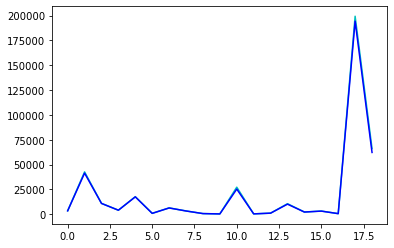

In [184]:
# Display the evolution of the initial and final loss values
plt.plot(init_losses,color='c')
plt.plot(final_losses,color='b')

<font color='blue'> We can see that the 2 curves or relatively similar. So we don't know if this optimization process is relevant. 
</font>  

We will finally focus on the IoU metric, that is easier to interpret.

<font color='blue'> Question 16: compute the mean and the standard deviation of the IoU values after optimization. Are the tumor cells on the available images circular ?
</font>  

In [186]:
# Compute and display the mean and standard deviation of the final IoU values
iou_mean = np.mean(final_ious)
iou_std = np.std(final_ious)
print("The mean of the final IoU values is", iou_mean)
print("The standard deviation of the final IoU values is", iou_std)

The mean of the final IoU values is 0.7886994280593607
The standard deviation of the final IoU values is 0.12073717400446293


<font color='blue'> We can see with the weak standard deviation and the high mean of the final IoU values that a big part is concentrated around 0.79. This means that the tumor cells' shape on the available images approximates circles.
</font>  

<font color='blue'> Question 17: compute and display the highest final IoU value, and superimpose on the associated input microscopic image the tumor contours (in green) and the contours of the optimized fitted circle (in blue).
</font>  

In [192]:
max_final_iou = max(final_ious)
print("The highest final IoU value is", max_final_iou)

The highest final IoU value is 0.9090909090909091


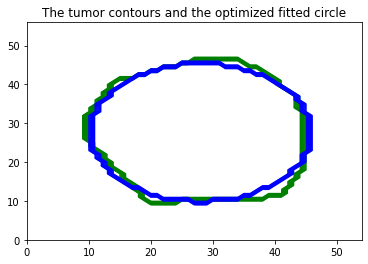

In [195]:
seg_arr = np.array(Image.open(segpaths[final_ious.index(max_final_iou)]))
seg_arr = (seg_arr>0).astype('int')
    
# Compute the distance map
map_arr = ndi.distance_transform_edt(seg_arr)
    
# Threshold the distance map
perim_arr = ((map_arr <= 1) & (seg_arr > 0)).astype(int)

[x, y] = np.where(perim_arr == 1)    

[x0, y0] = np.where(seg_arr == 1)
x0 = np.mean(x0)
y0 = np.mean(y0)
    
    # Initialize the radius
r0 = np.mean(np.sqrt((x-x0)**2+(y-y0)**2))

    # Create the binary image of the (filled) circle of center (x0, y0) and radius r0
sx, sy = seg_arr.shape
y_arr, x_arr = np.meshgrid(range(sy), range(sx))

circle_arr = (((x_arr - x0)**2+(y_arr-y0)**2)<=r0**2).astype(int)

    # Concatenate x and y
P = np.vstack((x, y))
    # Compute the vector of the z_i values
x = P[0, :]
y = P[1, :]
Z = x**2+y**2

    # Initialize the vector of variable values
p0 = [2*x0, 2*y0, r0**2-x0**2-y0**2]
alpha = p0[0]
beta = p0[1]
gamma = p0[2]
    
    # Display the initial loss value and iou
iou_initial = np.mean(circle_arr&seg_arr)/np.mean(circle_arr|seg_arr)
    # Fit the model using the Levenberg-Marquard method
lev_marq = optimize.curve_fit(predict,P,Z,p0=p0)
    
    # Display the optimized alpha, beta and gamma values
alpha_final = lev_marq[0][0]
beta_final = lev_marq[0][1]
gamma_final = lev_marq[0][2]

xc = alpha_final/2
yc = beta_final/2
r = np.sqrt(gamma_final+xc**2+yc**2)
    
    # Compute and display the final loss value and iou
Z_pred = predict(P,alpha_final,beta_final,gamma_final)    
circle_arr = (((x_arr - xc)**2+(y_arr-yc)**2)<=r**2).astype(int)
iou_final = np.mean(circle_arr&seg_arr)/np.mean(circle_arr|seg_arr)

plt.contour(seg_arr, colors = 'g')
plt.contour(circle_arr, colors = 'b')
plt.title('The tumor contours and the optimized fitted circle')
plt.show()

<font color='blue'> Question 18: compute and display the lowest final IoU value, and superimpose on the associated input microscopic image the tumor contours (in green) and the contours of the optimized fitted circle (in blue).
</font>  

In [196]:
lowest_final_iou = min(final_ious)
print("The highest final IoU value is", lowest_final_iou)

The highest final IoU value is 0.5047244094488189


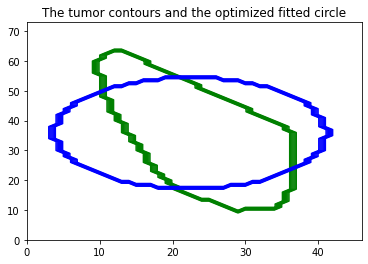

In [198]:
seg_arr = np.array(Image.open(segpaths[final_ious.index(lowest_final_iou)]))
seg_arr = (seg_arr>0).astype('int')
    
# Compute the distance map
map_arr = ndi.distance_transform_edt(seg_arr)
    
# Threshold the distance map
perim_arr = ((map_arr <= 1) & (seg_arr > 0)).astype(int)

[x, y] = np.where(perim_arr == 1)    

[x0, y0] = np.where(seg_arr == 1)
x0 = np.mean(x0)
y0 = np.mean(y0)
    
    # Initialize the radius
r0 = np.mean(np.sqrt((x-x0)**2+(y-y0)**2))

    # Create the binary image of the (filled) circle of center (x0, y0) and radius r0
sx, sy = seg_arr.shape
y_arr, x_arr = np.meshgrid(range(sy), range(sx))

circle_arr = (((x_arr - x0)**2+(y_arr-y0)**2)<=r0**2).astype(int)

    # Concatenate x and y
P = np.vstack((x, y))
    # Compute the vector of the z_i values
x = P[0, :]
y = P[1, :]
Z = x**2+y**2

    # Initialize the vector of variable values
p0 = [2*x0, 2*y0, r0**2-x0**2-y0**2]
alpha = p0[0]
beta = p0[1]
gamma = p0[2]
    
    # Display the initial loss value and iou
iou_initial = np.mean(circle_arr&seg_arr)/np.mean(circle_arr|seg_arr)
    # Fit the model using the Levenberg-Marquard method
lev_marq = optimize.curve_fit(predict,P,Z,p0=p0)
    
    # Display the optimized alpha, beta and gamma values
alpha_final = lev_marq[0][0]
beta_final = lev_marq[0][1]
gamma_final = lev_marq[0][2]

xc = alpha_final/2
yc = beta_final/2
r = np.sqrt(gamma_final+xc**2+yc**2)
    
    # Compute and display the final loss value and iou
Z_pred = predict(P,alpha_final,beta_final,gamma_final)    
circle_arr = (((x_arr - xc)**2+(y_arr-yc)**2)<=r**2).astype(int)
iou_final = np.mean(circle_arr&seg_arr)/np.mean(circle_arr|seg_arr)

plt.contour(seg_arr, colors = 'g')
plt.contour(circle_arr, colors = 'b')
plt.title('The tumor contours and the optimized fitted circle')
plt.show()

<font color='blue'> Question 19: superimpose on the same the initial IoU values (in cyan) and the optimized IoU values (in blue) for all input images. Does our method always increase the IoU ? What kind of method could we use to direclty optimize the IoU ? 
</font>  

In [231]:
len(init_ious)

19

In [232]:
init_ious

<function list.index(value, start=0, stop=9223372036854775807, /)>

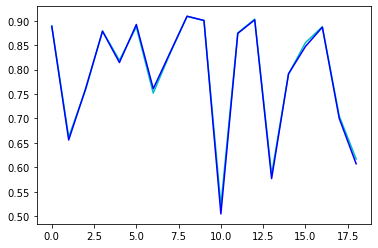

In [233]:
# Display the evolution of the initial and final IoU
plt.plot(init_ious,color='c')
plt.plot(final_ious,color='b')

<font color='blue'> We can see that sometimes our method doesn't increase the IoU everytime (per example when x = 15).
To optimize directly the IoU, we could use a method to minimize the cost between the initial and the final IoU (as we have seen, the method Nelder-Mead or Newton-CG for example).
</font>  